In [69]:
# Qiskit (anything not mentioned explicitly)
import numpy as np
import qiskit
# Backends
from qiskit.providers.aer import QasmSimulator, AerSimulator

# For analyzing vectors
from qiskit.quantum_info import Statevector

# Simulations of quantum machines
from qiskit.test.mock import FakeVigo, FakeYorktown, FakeMelbourne, FakeSingapore

# Custom noise model params
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error

from IPython import display

# What is Shor's Algorithm?

### Shor's algorithm can allow to factor a number N

Consider the following periodic function

$f(x) = a^x$ mod $N$

The period is the smallest nonzero $r$ such that

$a^r$ mod $N = 1$

If we can find $r$, we know that $a^r-1$ mod $N = 0$

And if $r$ is even,

$(a^r-1) = (a^{r/2} - 1)(a^{r/2} + 1)$

What did Shor's prove? He proved that the GCD of $N$ and either of $(a^{r/2} - 1),(a^{r/2} + 1)$ has a high probability of not being $1$ or $N$

### What do we do?

- 1) We randomly select $a$
- 2) We build a circuit that implements $a^r$
- 3) We use the Quantum Fourier transform to find the period of the output

# Implement Shor's Algorithm

## The 3 bit QFT

QFT inverse circuit


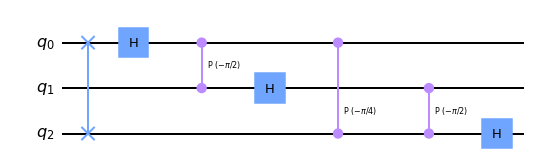

In [2]:
qft = qiskit.QuantumCircuit(3, name = "qft")
qft.h(2)
qft.cp(np.pi/2,1,2)
qft.cp(np.pi/4,0,2)
qft.h(1)
qft.cp(np.pi/2,0,1)
qft.h(0)
qft.swap(0,2)

qft_instr = qft.to_instruction()
qft_inverse = qiskit.QuantumCircuit(3, name="qft^-1")
qft_inverse.swap(0,2)
qft_inverse.h(0)
qft_inverse.cp(-np.pi/2, 0, 1)
qft_inverse.h(1)
qft_inverse.cp(-np.pi/4, 0, 2)
qft_inverse.cp(-np.pi/2, 1, 2)
qft_inverse.h(2)
qft_inverse_instr = qft_inverse.to_instruction()
print("QFT inverse circuit")
qft_inverse.draw('mpl')

## Without any assertions

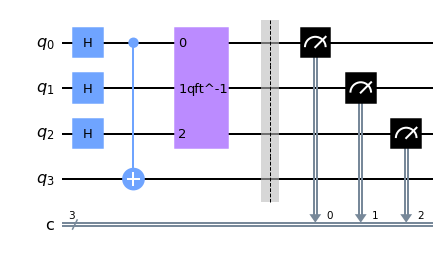

In [3]:
shors_full_noassert = qiskit.QuantumCircuit(4, 3, name = 'shors')
# shors_full.rx(0.2*np.pi, range(5)) # Noise
# shors_full.rx(0.2*np.pi, range(5)) # Noise
shors_full_noassert.h(0)
shors_full_noassert.h(1)
shors_full_noassert.h(2)


shors_full_noassert.cx(0,3)


shors_full_noassert.append(qft_inverse_instr, [0,1,2])

shors_full_noassert.barrier(range(4))
shors_full_noassert.measure(range(3), range(3))
shors_full_noassert.draw('mpl')

## With assertions 

### A0

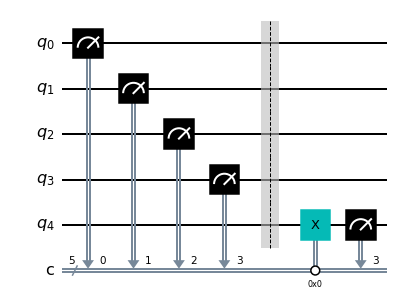

In [4]:
assert0_base = qiskit.QuantumCircuit(5,5, name="assert0")
assert0_base.measure(range(4),range(4))
assert0_base.barrier(range(5))
assert0_cond = qiskit.QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";

qreg q[5]; // Quantum Register
creg c[5]; // Classical Register
 
if (c==0) x q[4]; // q[4] == 1 means assertion passed
""")
assert0 = assert0_base.compose(assert0_cond, range(5), front = False)
assert0.measure(4,3)
assert0_instr = assert0.to_instruction()
assert0.draw('mpl')

### A1

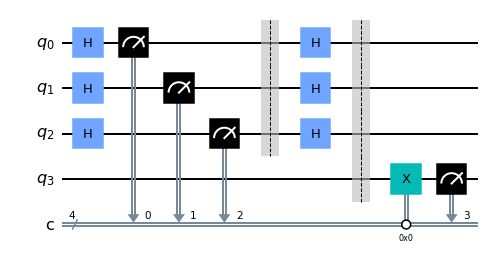

In [5]:
assert_1_base = qiskit.QuantumCircuit(4,4, name = "assert1")
assert_1_base.h(range(3))
assert_1_base.measure(range(3),range(3))
assert_1_base.barrier(range(3))
assert_1_base.h(range(3))
assert_1_base.barrier(range(4))
assert1_cond = qiskit.QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";

qreg q[4]; // Quantum Register
creg c[4]; // Classical Register
 
if (c==0) x q[3]; // q[3] == 1 means assertion passed
""")
assert1 = assert_1_base.compose(assert1_cond, range(4), front = False)
assert1.measure(3,3)
assert1_instr = assert1.to_instruction()
assert1.draw('mpl')

### A2

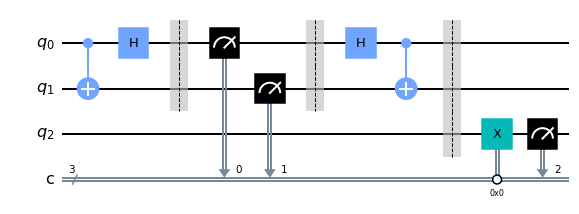

In [6]:
assert2_base = qiskit.QuantumCircuit(3,3, name = "assert2")
assert2_base.cx(0,1)
assert2_base.h(0)
assert2_base.barrier(range(2))
assert2_base.measure(range(2),range(2))
assert2_base.barrier(range(2))
assert2_base.h(0)
assert2_base.cx(0,1)
assert2_base.barrier(range(3))
assert2_cond = qiskit.QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";

qreg q[3]; // Quantum Register
creg c[3]; // Classical Register
 
if (c==0) x q[2]; // q[2] == 1 means assertion passed
""")
assert2 = assert2_base.compose(assert2_cond, range(3), front = False)
assert2.measure(2,2)
assert2_instr = assert2.to_instruction()
assert2.draw('mpl')

### A3
Modified from the Authors' version. We don't think they did it right!

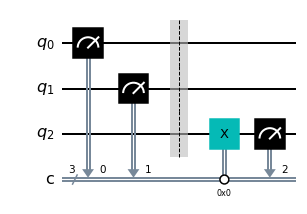

In [7]:
assert3_base = qiskit.QuantumCircuit(3,3, name = "assert3")
assert3_base.measure(range(2),range(2))
assert3_base.barrier(range(3))
assert3_cond = qiskit.QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";

qreg q[3]; // Quantum Register
creg c[3]; // Classical Register
 
if (c==0) x q[2]; // q[2] == 1 means assertion passed
""")
assert3 = assert3_base.compose(assert3_cond, range(3), front = False)
assert3.measure(2,2)
assert3_instr = assert3.to_instruction()
assert3.draw('mpl')

### The algorithm itself

/home/dsmishler/anaconda3/lib/python3.8/site-packages/qiskit/visualization/matplotlib.py:317: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  self._get_layer_widths()


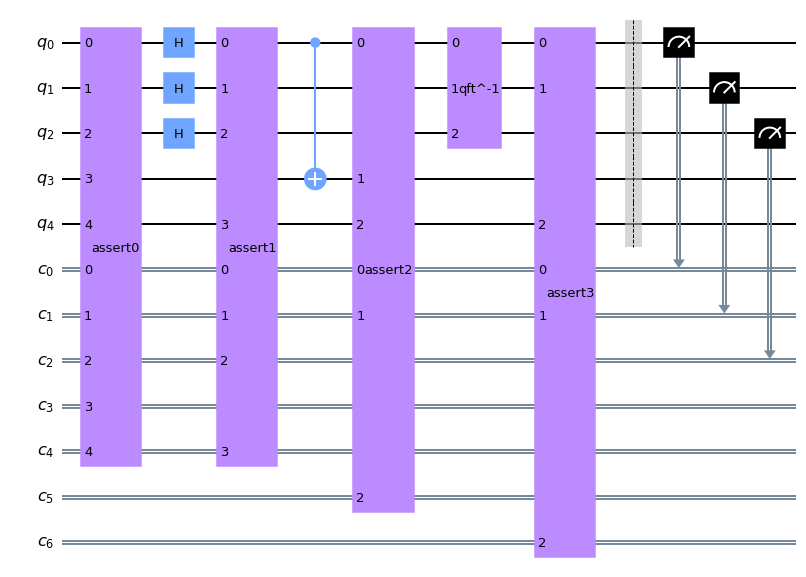

In [8]:
shors_full = qiskit.QuantumCircuit(5, 7, name = 'shors')
# shors_full.rx(0.2*np.pi, range(5)) # Noise
shors_full.append(assert0_instr, [0,1,2,3,4], [0,1,2,3,4])
# shors_full.rx(0.2*np.pi, range(5)) # Noise
shors_full.h(0)
shors_full.h(1)
shors_full.h(2)

shors_full.append(assert1_instr, [0,1,2,4], [0,1,2,4])

shors_full.cx(0,3)

shors_full.append(assert2_instr, [0,3,4], [0,1,5])

shors_full.append(qft_inverse_instr, [0,1,2])

shors_full.append(assert3_instr, [0,1,4], [0,1,6])

shors_full.barrier(range(5))
shors_full.measure(range(3), range(3))
shors_full.draw('mpl')

# Running the algorithm

## Ideal

### No asserts

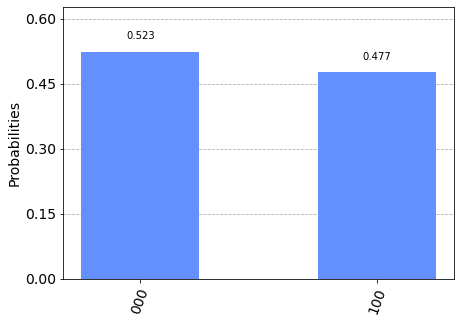

In [9]:
backend = QasmSimulator()
circ_compiled = qiskit.transpile(shors_full_noassert, backend)
job_sim = backend.run(circ_compiled, shots = 3000)
results_sim = job_sim.result()
counts = results_sim.get_counts(circ_compiled)
qiskit.visualization.plot_histogram(counts)

### With asserts

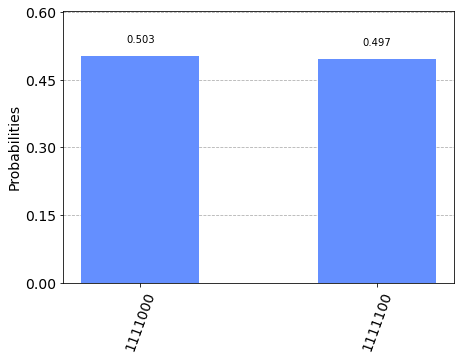

In [10]:
backend = QasmSimulator()
circ_compiled = qiskit.transpile(shors_full, backend)
job_sim = backend.run(circ_compiled, shots = 3000)
results_sim = job_sim.result()
counts = results_sim.get_counts(circ_compiled)
qiskit.visualization.plot_histogram(counts)

## Adding noise

### Parsing helper functions

In [11]:
def pop_via_threshold(data, pop_threshold = 5):
    to_pop = []
    counts_noise = data
    for entry in counts_noise:
        if(counts_noise[entry] < pop_threshold):
            # print("filtering out", entry)
            to_pop.append(entry)
    counts_noise["other"] = 0
    for item in to_pop:
        counts_noise["other"] += counts_noise[item]
        counts_noise.pop(item)
    return counts_noise

def group_failed_assertions(data):
    num_assertions = 4
    failed_assertions = {}
    for i in range(num_assertions):
        to_pop = []
        threshold = 0
        for j in range(i+1):
            threshold += 2**(6-j)
        for entry in data:
            if(int(entry,base=2) < threshold):
                to_pop.append(entry)
        failed_assertions["assertion %d failed" % i] = 0
        for item in to_pop:
            failed_assertions["assertion %d failed" % i] += data[item]
            data.pop(item)
    for entry in failed_assertions:
        data[entry] = failed_assertions[entry]
    return data

def remove_failed_assertions(data):
    num_assertions = 4
    failed_assertions = {}
    for i in range(num_assertions):
        to_pop = []
        threshold = 0
        for j in range(i+1):
            threshold += 2**(6-j)
        for entry in data:
            if(int(entry,base=2) < threshold):
                to_pop.append(entry)
        failed_assertions["assertion %d failed" % i] = 0
        for item in to_pop:
            failed_assertions["assertion %d failed" % i] += data[item]
            data.pop(item)
    return data

def get_shors_failure_rate(data):
    success_counts = 0
    failure_counts = 0
    for entry in data:
        if(entry[-3:] == "000" or entry[-3:] == "100"):
            success_counts += data[entry]
        else:
            failure_counts += data[entry]
    return (failure_counts)/(failure_counts+success_counts)

### Low levels of noise

In [12]:
p_reset_error = 0.001
p_measure_error = 0.001
p_1gate_error = 0.001

# These are only bit-flip errors. There are other errors out there!
error_reset   = pauli_error([('X',p_reset_error),('I',1-p_reset_error)])
error_measure = pauli_error([('X',p_measure_error),('I',1-p_measure_error)])
error_1gate   = pauli_error([('X',p_1gate_error),('I',1-p_1gate_error)])
error_2gate   = error_1gate.tensor(error_1gate)



custom_noise_model = NoiseModel()
custom_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
custom_noise_model.add_all_qubit_quantum_error(error_measure, "measurement")
custom_noise_model.add_all_qubit_quantum_error(error_1gate, ["u1", "u2", "u3"])
custom_noise_model.add_all_qubit_quantum_error(error_2gate, "cx")
print(custom_noise_model)

sim_custom_noise = AerSimulator(noise_model = custom_noise_model)
assert_circ = qiskit.transpile(shors_full, sim_custom_noise)
noassert_circ = qiskit.transpile(shors_full_noassert, sim_custom_noise)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2', 'reset', 'measurement', 'u1', 'u3']
  All-qubits errors: ['reset', 'measurement', 'u1', 'u2', 'u3', 'cx']


failure rate:  0.0102


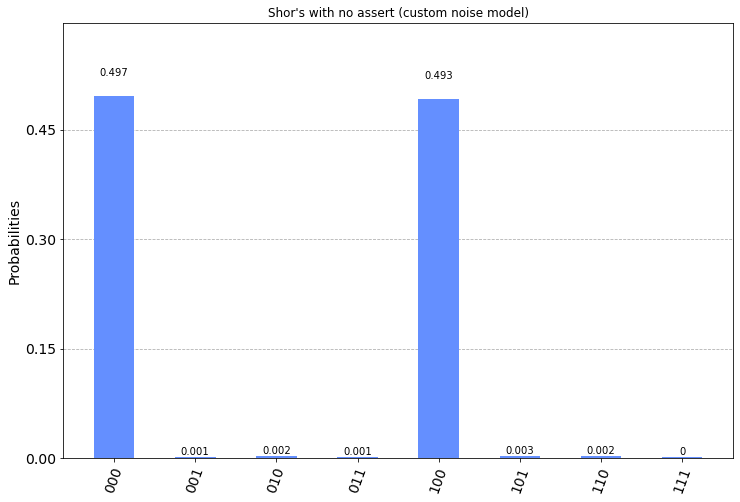

In [13]:
# Execute noisy simulation and get counts
result_noassert = sim_custom_noise.run(noassert_circ, shots=5000).result()
counts_noassert = result_noassert.get_counts(0)
print("failure rate: ", get_shors_failure_rate(counts_noassert))
qiskit.visualization.plot_histogram(counts_noassert,
                                   #number_to_keep=5,
                                   figsize = [12,8],
                                   #sort = 'desc',
                                   title="Shor's with no assert (custom noise model)")

failure rate:  0.010406243746247748


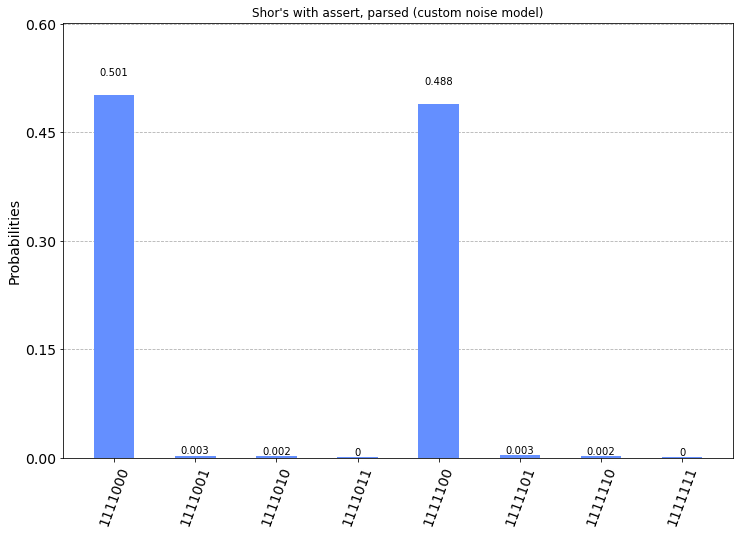

In [14]:
result_assert = sim_custom_noise.run(assert_circ, shots=5000).result()
counts_assert = result_assert.get_counts(0)
counts_noise_parsed = remove_failed_assertions(counts_assert)
print("failure rate: ", get_shors_failure_rate(counts_noise_parsed))
qiskit.visualization.plot_histogram(counts_noise_parsed,
                               #number_to_keep=5,
                               figsize = [12,8],
                               #sort = 'desc',
                               title="Shor's with assert, parsed (custom noise model)")

### Medium levels of noise

In [15]:
p_reset_error = 0.02
p_measure_error = 0.02
p_1gate_error = 0.02

# These are only bit-flip errors. There are other errors out there!
error_reset   = pauli_error([('X',p_reset_error),('I',1-p_reset_error)])
error_measure = pauli_error([('X',p_measure_error),('I',1-p_measure_error)])
error_1gate   = pauli_error([('X',p_1gate_error),('I',1-p_1gate_error)])
error_2gate   = error_1gate.tensor(error_1gate)



custom_noise_model = NoiseModel()
custom_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
custom_noise_model.add_all_qubit_quantum_error(error_measure, "measurement")
custom_noise_model.add_all_qubit_quantum_error(error_1gate, ["u1", "u2", "u3"])
custom_noise_model.add_all_qubit_quantum_error(error_2gate, "cx")
print(custom_noise_model)

sim_custom_noise = AerSimulator(noise_model = custom_noise_model)
assert_circ = qiskit.transpile(shors_full, sim_custom_noise)
noassert_circ = qiskit.transpile(shors_full_noassert, sim_custom_noise)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2', 'reset', 'measurement', 'u1', 'u3']
  All-qubits errors: ['reset', 'measurement', 'u1', 'u2', 'u3', 'cx']


failure rate:  0.181


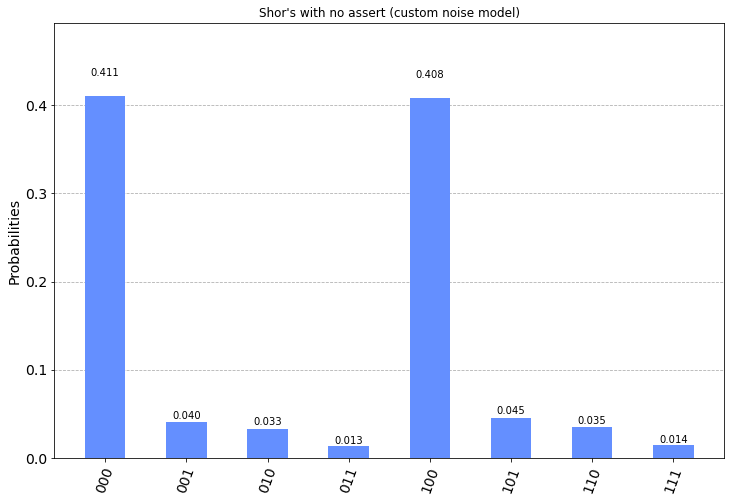

In [16]:
# Execute noisy simulation and get counts
result_noassert = sim_custom_noise.run(noassert_circ, shots=5000).result()
counts_noassert = result_noassert.get_counts(0)
print("failure rate: ", get_shors_failure_rate(counts_noassert))
qiskit.visualization.plot_histogram(counts_noassert,
                                   #number_to_keep=5,
                                   figsize = [12,8],
                                   #sort = 'desc',
                                   title="Shor's with no assert (custom noise model)")

failure rate:  0.18307849133537207


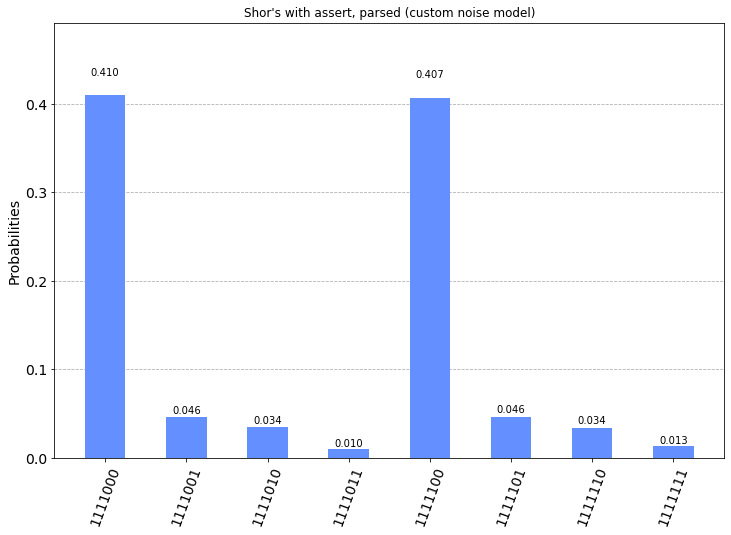

In [17]:
result_assert = sim_custom_noise.run(assert_circ, shots=5000).result()
counts_assert = result_assert.get_counts(0)
counts_noise_parsed = remove_failed_assertions(counts_assert)
print("failure rate: ", get_shors_failure_rate(counts_noise_parsed))
qiskit.visualization.plot_histogram(counts_noise_parsed,
                               #number_to_keep=5,
                               figsize = [12,8],
                               #sort = 'desc',
                               title="Shor's with assert, parsed (custom noise model)")

### High levels of noise

In [33]:
p_reset_error = 0.3
p_measure_error = 0.3
p_1gate_error = 0.3

# These are only bit-flip errors. There are other errors out there!
error_reset   = pauli_error([('X',p_reset_error),('I',1-p_reset_error)])
error_measure = pauli_error([('X',p_measure_error),('I',1-p_measure_error)])
error_1gate   = pauli_error([('X',p_1gate_error),('I',1-p_1gate_error)])
error_2gate   = error_1gate.tensor(error_1gate)



custom_noise_model = NoiseModel()
custom_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
custom_noise_model.add_all_qubit_quantum_error(error_measure, "measurement")
custom_noise_model.add_all_qubit_quantum_error(error_1gate, ["u1", "u2", "u3"])
custom_noise_model.add_all_qubit_quantum_error(error_2gate, "cx")
print(custom_noise_model)

sim_custom_noise = AerSimulator(noise_model = custom_noise_model)
assert_circ = qiskit.transpile(shors_full, sim_custom_noise)
noassert_circ = qiskit.transpile(shors_full_noassert, sim_custom_noise)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2', 'reset', 'measurement', 'u1', 'u3']
  All-qubits errors: ['reset', 'measurement', 'u1', 'u2', 'u3', 'cx']


failure rate:  0.098


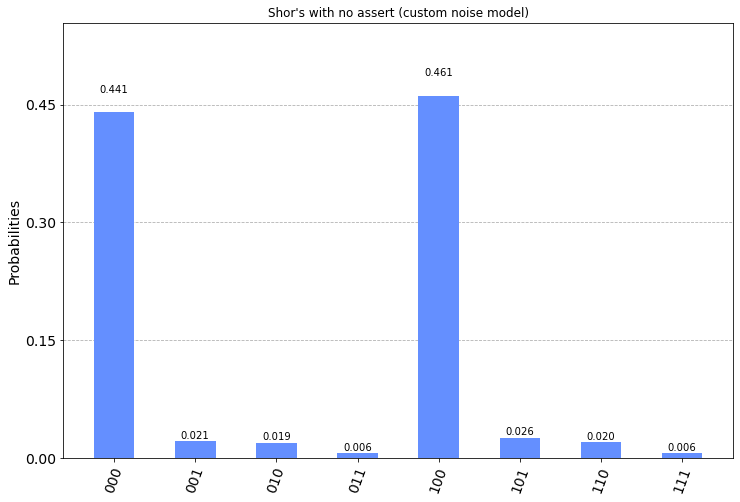

In [34]:
# Execute noisy simulation and get counts
result_noassert = sim_custom_noise.run(noassert_circ, shots=5000).result()
counts_noassert = result_noassert.get_counts(0)
print("failure rate: ", get_shors_failure_rate(counts_noassert))
qiskit.visualization.plot_histogram(counts_noassert,
                                   #number_to_keep=5,
                                   figsize = [12,8],
                                   #sort = 'desc',
                                   title="Shor's with no assert (custom noise model)")

failure rate:  0.09048582995951417


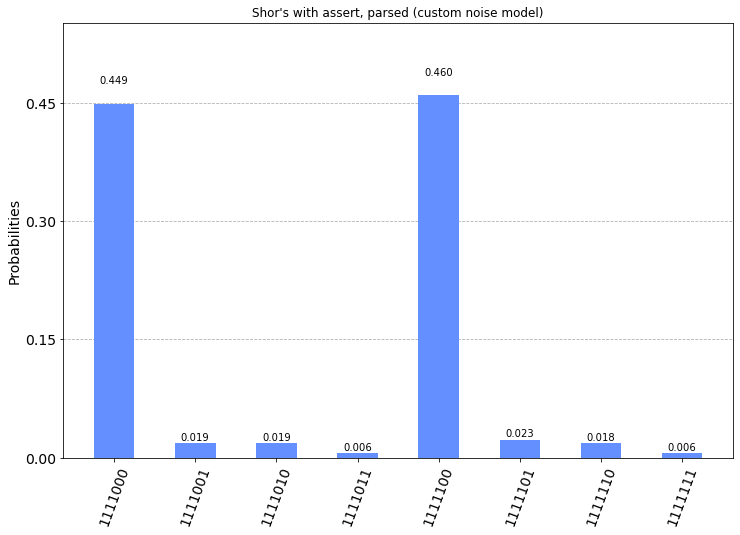

In [35]:
result_assert = sim_custom_noise.run(assert_circ, shots=5000).result()
counts_assert = result_assert.get_counts(0)
counts_noise_parsed = remove_failed_assertions(counts_assert)
print("failure rate: ", get_shors_failure_rate(counts_noise_parsed))
qiskit.visualization.plot_histogram(counts_noise_parsed,
                               #number_to_keep=5,
                               figsize = [12,8],
                               #sort = 'desc',
                               title="Shor's with assert, parsed (custom noise model)")

### Try a simulated system (Yorktown)

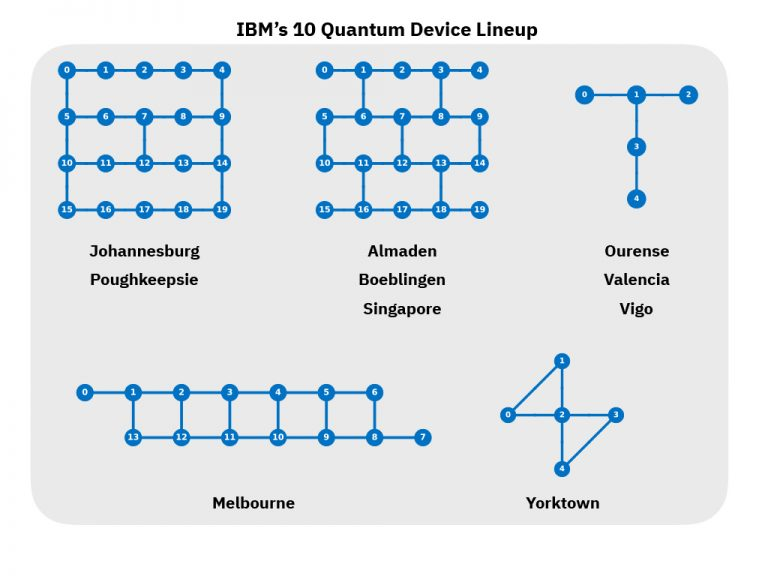

In [62]:
display.Image("IBM-systems.jpg")

In [70]:
# Yorktown : ~20% failure and asserts don't help
# Vigo: ~15% failure without asserts, ~10% with asserts
# Melbourne: ~16% without asserts, ~23% with asserts
# Signapore: similar to Melbourne
device_backend = FakeSingapore()
sim_real = AerSimulator.from_backend(device_backend)
assert_circ = qiskit.transpile(shors_full, sim_real)
noassert_circ = qiskit.transpile(shors_full_noassert, sim_real)

failure rate:  0.13844


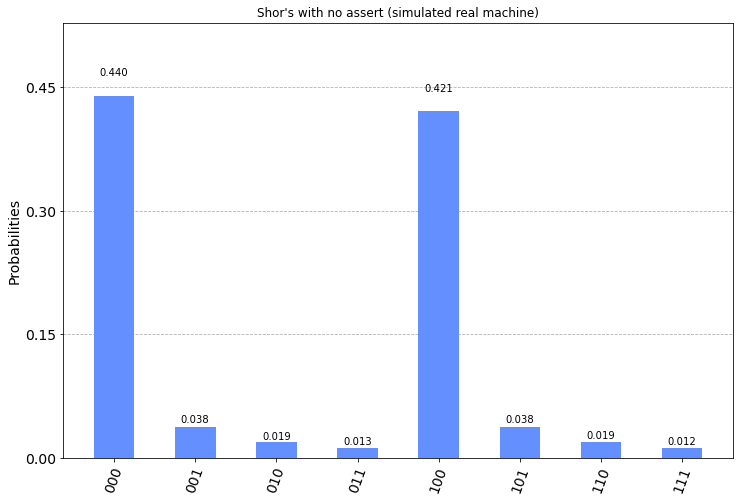

In [73]:
# Execute noisy simulation and get counts
result_noassert = sim_real.run(noassert_circ, shots=50000).result()
counts_noassert = result_noassert.get_counts(0)
print("failure rate: ", get_shors_failure_rate(counts_noassert))
qiskit.visualization.plot_histogram(counts_noassert,
                                   #number_to_keep=5,
                                   figsize = [12,8],
                                   #sort = 'desc',
                                   title="Shor's with no assert (simulated real machine)")

failure rate:  0.20837117367380736


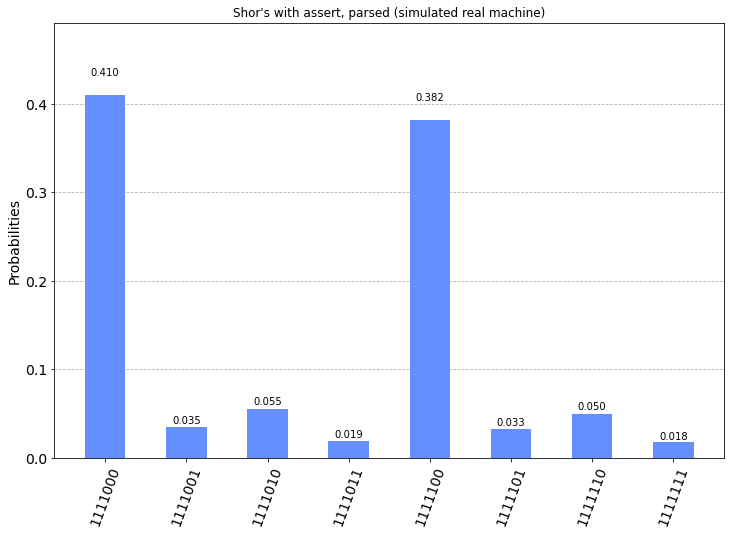

In [74]:
result_assert = sim_real.run(assert_circ, shots=50000).result()
counts_assert = result_assert.get_counts(0)
counts_noise_parsed = remove_failed_assertions(counts_assert)
print("failure rate: ", get_shors_failure_rate(counts_noise_parsed))
qiskit.visualization.plot_histogram(counts_noise_parsed,
                               #number_to_keep=5,
                               figsize = [12,8],
                               #sort = 'desc',
                               title="Shor's with assert, parsed (simulated real machine)")